<a href="https://colab.research.google.com/github/Shelly10-10/flood_prediction/blob/main/disaster.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
#Read the dataset
import pandas as pd
import numpy as np

df = pd.read_csv("improved_flood_dataset.csv")

print(df.shape)
print(df.columns)
print(df['Flood_Reported'].value_counts())


(10000, 19)
Index(['Region', 'Latitude', 'Longitude', 'Date', 'Rainfall_mm',
       'Tide_Level_m', 'Soil_Saturation_%', 'River_Level_m',
       'Land_Elevation_m', 'Distance_to_Coast_km', 'Cyclone_Alert',
       'Temperature_C', 'Humidity_%', 'Wind_Speed_kmph', 'Evaporation_mm',
       'Satellite_Cloud_Index', 'Infrastructure_Grade', 'Flood_Risk_Score',
       'Flood_Reported'],
      dtype='object')
Flood_Reported
0    7136
1    2864
Name: count, dtype: int64


In [ ]:
#Dropping the target column
# Date processing
from sklearn.metrics import confusion_matrix

grade_mapping = {
    'A':4,
    'B':3,
    'C':2,
    'D':1,
    'E':0
}
df['Infrastructure_Grade'] = df['Infrastructure_Grade'].map(grade_mapping)
df['Date'] = pd.to_datetime(df['Date'])
df['Month'] = df['Date'].dt.month

# Target
y = df['Flood_Reported']

# Features
drop_cols = [
    'Flood_Reported',
    'Flood_Risk_Score',
    'Region',
    'Date'
]

X = df.drop(columns=drop_cols)



In [ ]:
#Train test split
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
#Handling missing value
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy='median')
X_train_imp = imputer.fit_transform(X_train)
X_test_imp = imputer.transform(X_test)


In [ ]:
#Scaling
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_imp)
X_test_scaled = scaler.transform(X_test_imp)


In [ ]:
#Model implementation
#Random Forest
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=200,
    max_depth=15,
    random_state=42,
    class_weight='balanced'
)

rf_model.fit(X_train_imp, y_train)
#Evaluation report of random forest
from sklearn.metrics import classification_report

y_pred_rf = rf_model.predict(X_test_imp)
print(classification_report(y_test, y_pred_rf))


              precision    recall  f1-score   support

           0       0.97      0.97      0.97      1427
           1       0.93      0.92      0.92       573

    accuracy                           0.96      2000
   macro avg       0.95      0.95      0.95      2000
weighted avg       0.96      0.96      0.96      2000



In [15]:
import shap

explainer = shap.Explainer(rf_model, X)
shap_values = explainer(X)



100%|===================| 19992/20000 [13:36<00:00]       

In [13]:
print("X shape:", X.shape)
print("Model expects:", rf_model.n_features_in_)
print("SHAP values shape:", np.array(shap_values[1]).shape)


X shape: (10000, 16)
Model expects: 16
SHAP values shape: (16, 2)


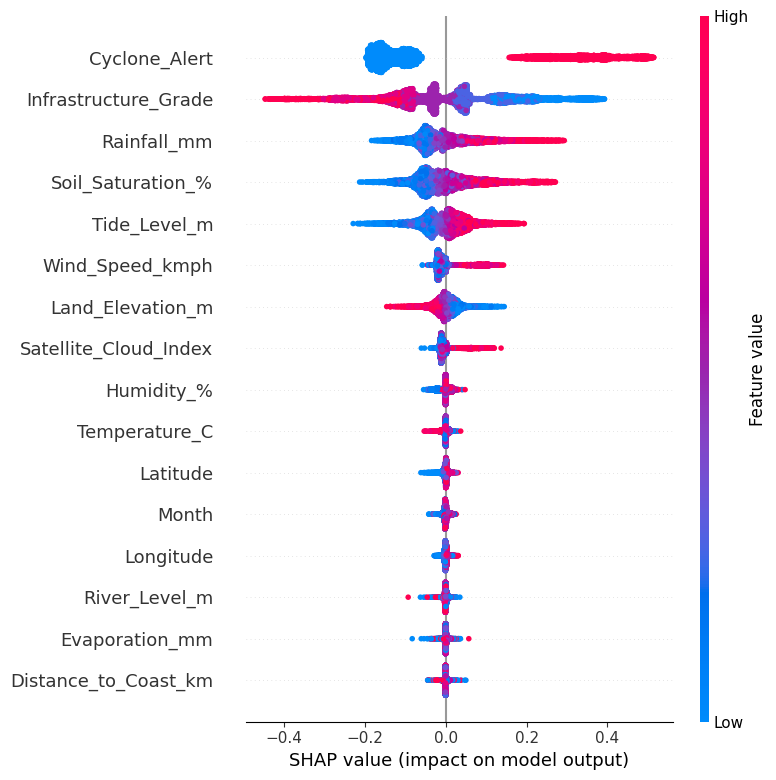

In [16]:
shap.summary_plot(
    shap_values.values[:, :, 1],  # class = Flood (1)
    X,
    plot_type="dot",
    max_display=20
)



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


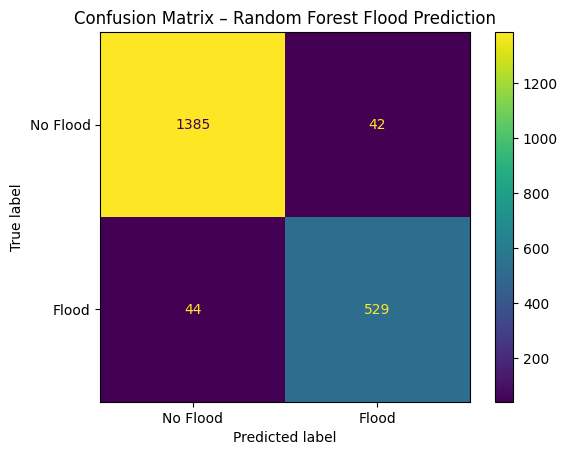

In [17]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = rf_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Flood", "Flood"]
)

disp.plot()
plt.title("Confusion Matrix – Random Forest Flood Prediction")
plt.show()


In [18]:
#XGBOOST
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=300,
    max_depth=6,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train_imp, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.05, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=300, n_jobs=None,
              num_parallel_tree=None, ...)

In [27]:
from sklearn.metrics import classification_report

y_pred_xgb = xgb_model.predict(X_test_imp)
print(classification_report(y_test, y_pred_xgb,digits=4))

              precision    recall  f1-score   support

           0     0.9860    0.9874    0.9867      1427
           1     0.9685    0.9651    0.9668       573

    accuracy                         0.9810      2000
   macro avg     0.9772    0.9762    0.9767      2000
weighted avg     0.9810    0.9810    0.9810      2000



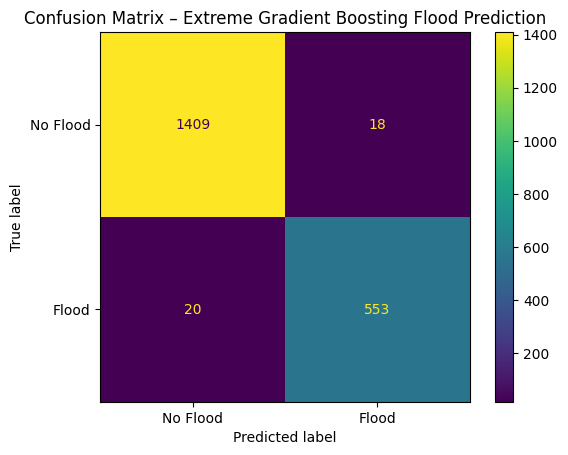

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict on test data
y_pred = xgb_model.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot confusion matrix
disp = ConfusionMatrixDisplay(
    confusion_matrix=cm,
    display_labels=["No Flood", "Flood"]
)

disp.plot()
plt.title("Confusion Matrix – Extreme Gradient Boosting Flood Prediction")
plt.show()


100%|===================| 9975/10000 [03:05<00:00]       

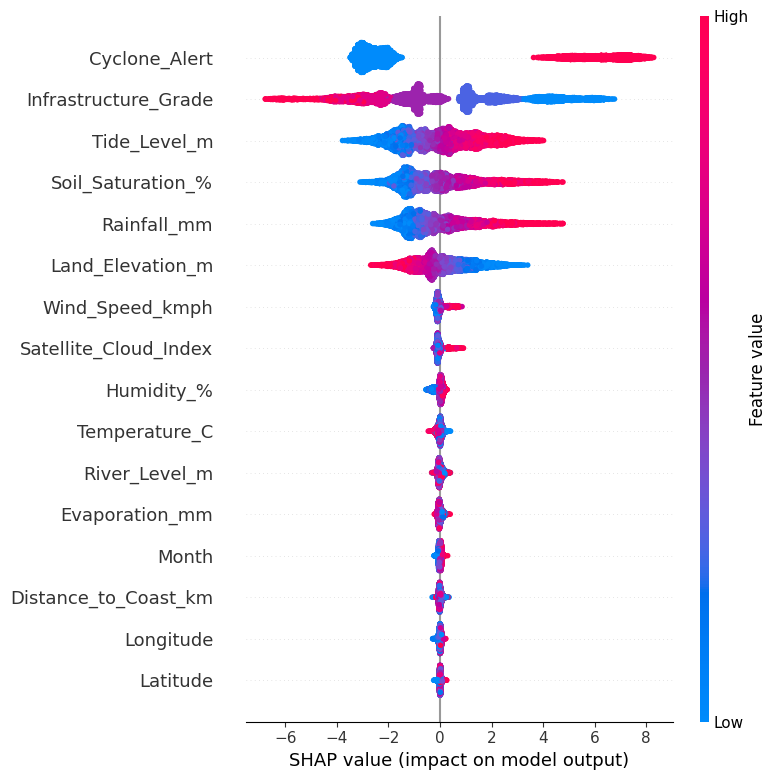

In [25]:
import shap

explainer_xgb = shap.Explainer(xgb_model, X)
shap_values_xgb = explainer_xgb(X)



shap.summary_plot(
    shap_values_xgb.values,  # class = Flood (1)
    X,
    plot_type="dot",
    max_display=20
)
